# AIDS Classification Project

# Imports

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV

# Model Processing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN
from sklearn.decomposition import PCA

# K Best columns
from sklearn.feature_selection import SelectKBest, mutual_info_classif, f_classif


from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2, l1
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

# Functions

In [68]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
    
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores


def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        pipeline = Pipeline(steps=[('scaler', StandardScaler()), ("power_tranformer",PowerTransformer()), ('model', model)])
        scores = evaluate_model(X, y, pipeline)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def get_over_sampling_methods(X, y, name):
  
  sampling_models = {
    "KNN-SMOTE":SMOTE(k_neighbors=5, random_state=42),
    "BL-SMOTE": BorderlineSMOTE(kind='borderline-1', random_state=42),
    "SMOTE": SMOTE(),
    "ADASYN": ADASYN(random_state=42)
  }
  
  smapling_model = sampling_models[name]
  X_res, y_res = smapling_model.fit_resample(X, y)
    
  return (X_res, y_res)

def svm_tune_grid_search(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', SVC())
    ])
    
    param_grid = {
        'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
    }
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_test_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for SVC')
    plt.show()
    
    return grid_search

def logistic_regression_tune_cv(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', LogisticRegression(class_weight='balanced', penalty='l2', max_iter=2000))
    ])
    param_grid = {
        'model__solver': ['newton-cg', 'sag', 'saga', 'lbfgs'],
        'model__C': [0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10, 20, 50, 100, 400]
    }
    metric = make_scorer(f1_score)
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring=metric, n_jobs=-1)
    grid_search.fit(X_train, y_train)
    
    print("Best parameters:", grid_search.best_params_)
    print("Best cross-validation score: {:.3f}".format(grid_search.best_score_))
    
    y_test_pred = grid_search.predict(X_test)
    accuracy = accuracy_score(y_test, y_test_pred)
    print(f'Test accuracy: {accuracy:.3f}')
    cr = classification_report(y_test, y_test_pred)
    print(cr)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(8,6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix for SVC')
    plt.show()

def val_grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', model)
    ])
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        y_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)
        
        val_accuracy = accuracy_score(y_val, y_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)    
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Validation Test accuracy for {name}: {val_accuracy:.3f}')
        print(f'Test accuracy for {name}: {test_accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_test_pred)
        cr = classification_report(y_test, y_test_pred)
        print(cr)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Validation Accuracy": val_accuracy,
                "Test Accuracy": test_accuracy,
                "Best Parameters": grid_search.best_params_
        })

def val_grid_search_selected_models(param_grid:dict,names:list, models:list, X:pd.DataFrame, y:pd.Series, metric):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    model_performance = []

    for i in range(len(models)):
        model, name = models[i], names[i]
        pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('power_transformer', PowerTransformer()),
        ('model', model)
    ])
        grid_search = GridSearchCV(pipeline, param_grid[name], cv=5, scoring=metric, n_jobs=-1)
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
            
        y_pred = best_model.predict(X_val)
        y_test_pred = best_model.predict(X_test)
        
        val_accuracy = accuracy_score(y_val, y_pred)
        test_accuracy = accuracy_score(y_test, y_test_pred)    
        print(f'Best score for {name}: {grid_search.best_score_:.3f}')
        print("Best parameters:", grid_search.best_params_)
        
        print(f'Validation Test accuracy for {name}: {val_accuracy:.3f}')
        print(f'Test accuracy for {name}: {test_accuracy:.3f}')
        print("---------------------------------------------------------------")
        
        conf_mat = confusion_matrix(y_test, y_test_pred)
        cr = classification_report(y_test, y_test_pred)
        print(cr)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix for {names[i]}')
        plt.show()
            
        model_performance.append({
                "Model": name,
                "Best CV Score": grid_search.best_score_,
                "Validation Accuracy": val_accuracy,
                "Test Accuracy": test_accuracy,
                "Best Parameters": grid_search.best_params_
        })


def pca_analysis(X):
  scaler = StandardScaler()
  X_scaled = scaler.fit_transform(X)
  
  features = X.shape[1]
  results = []
  for n_components in range(1, features + 1):
        pca = PCA(n_components=n_components)
        X_pca = pca.fit_transform(X_scaled)
        
        explained_variance = np.sum(pca.explained_variance_ratio_)
        
        results.append({
            'Number of Components': n_components,
            'Cumulative Explained Variance': explained_variance
        })
  results_df = pd.DataFrame(results)
  return results_df

def test_k_best_columns(names, models, X, y, metric, metric_name, variance_window):
    
    
    model_performance = []
    for k in variance_window:
        fs = SelectKBest(score_func=metric, k=k)
        for i in range(len(models)):
            model = models[i]
            pipeline = Pipeline(steps=
                                [('scaler', StandardScaler()), 
                                ("power_tranformer",PowerTransformer()), 
                                (metric_name, fs),
                                ('model', model)])
            scores = evaluate_model(X, y, pipeline)
            model_performance.append({
                "Model": names[i],
                "Col #": k,
                "Metric": metric_name,
                "Mean": np.mean(scores),
                "STD":np.std(scores)
            })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)

def test_train_test_val_splits_on_models(names, models, X, y, kbest, kbest_name):
    model_performance = []
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
    
    for i in range(len(models)):
        model, model_name = models[i], names[i]
        pipeline = Pipeline(steps=[
            ('scaler', StandardScaler()), 
            ("power_tranformer",PowerTransformer()), 
            (kbest_name, SelectKBest(score_func=f_classif, k=kbest)),
            ('model', model)])
        pipeline.fit(X_train, y_train)
        
        y_val_pred = pipeline.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        y_test_pred = pipeline.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        model_performance.append({
            "Model": model_name,
            "Validation Accuracy": val_accuracy,
            "Test Accuracy": test_accuracy
        })
        cr = classification_report(y_test, y_test_pred)
        print(cr)
        conf_mat = confusion_matrix(y_test,y_test_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix {model_name}')
        plt.show()
        
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Test Accuracy", ascending=False)

# Problem Objective:

# We want to reduce the amount of false negatives as this can potentially destroy lives, however do we want a metric that favors solely suppressing false negatives over false positives? What is the ethical thing to do here? 

# To supress False negatives we focus on scoring by F2 score
# To give equal weight to false negatives and fale positives then we score by F1

# I don't know the legal or ethical requirements here, however I will base my model on the F1 score in this case.

# EDA Analysis

In [4]:
df = pd.read_csv("/Users/maukanmir/Downloads/archive/AIDS_Classification.csv", nrows=20000)
df

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
0,948,2,48,89.8128,0,0,0,100,0,0,...,0,1,0,1,0,422,477,566,324,0
1,1002,3,61,49.4424,0,0,0,90,0,1,...,1,3,0,1,0,162,218,392,564,1
2,961,3,45,88.4520,0,1,1,90,0,1,...,1,3,0,1,1,326,274,2063,1893,0
3,1166,3,47,85.2768,0,1,0,100,0,1,...,1,3,0,1,0,287,394,1590,966,0
4,1090,0,43,66.6792,0,1,0,100,0,1,...,1,3,0,0,0,504,353,870,782,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2134,1091,3,21,53.2980,1,0,0,100,0,1,...,1,3,0,1,1,152,109,561,720,0
2135,395,0,17,102.9672,1,0,0,100,0,1,...,1,3,0,0,1,373,218,1759,1030,0
2136,1104,2,53,69.8544,1,1,0,90,0,1,...,1,3,0,1,0,419,364,1391,1041,0
2137,465,0,14,60.0000,1,0,0,100,0,0,...,0,1,0,0,0,166,169,999,1838,1


# Check For Nulls and Dupes

In [5]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: time        0
trt         0
age         0
wtkg        0
hemo        0
homo        0
drugs       0
karnof      0
oprior      0
z30         0
preanti     0
race        0
gender      0
str2        0
strat       0
symptom     0
treat       0
offtrt      0
cd40        0
cd420       0
cd80        0
cd820       0
infected    0
dtype: int64
Dupe Count: 0


# Check For Class Imbalance

Class=0, Count=1618, Percentage=75.643%
Class=1, Count=521, Percentage=24.357%


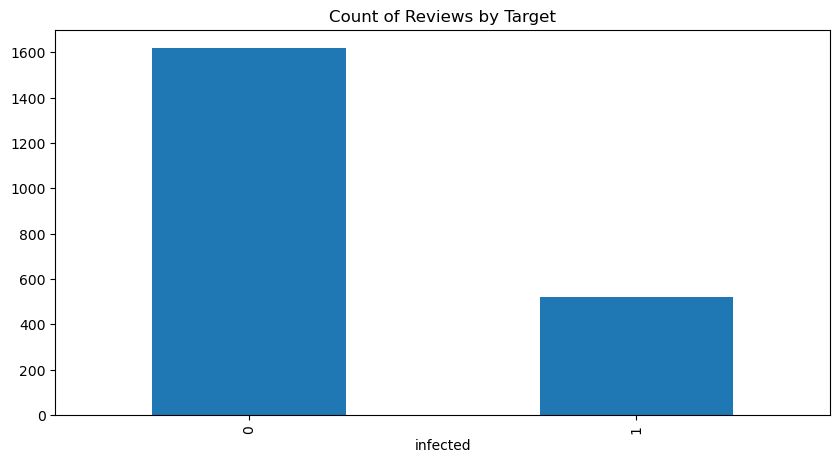

In [6]:
check_class_imbalance(df,df['infected'], 'infected')

# Imbalanced Dataset, we will have to test with over sampling methods

In [7]:
df.dtypes

time          int64
trt           int64
age           int64
wtkg        float64
hemo          int64
homo          int64
drugs         int64
karnof        int64
oprior        int64
z30           int64
preanti       int64
race          int64
gender        int64
str2          int64
strat         int64
symptom       int64
treat         int64
offtrt        int64
cd40          int64
cd420         int64
cd80          int64
cd820         int64
infected      int64
dtype: object

In [8]:
df.describe()

,time,trt,age,wtkg,hemo,homo,drugs,karnof,oprior,z30,...,str2,strat,symptom,treat,offtrt,cd40,cd420,cd80,cd820,infected
count,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,...,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000,2139.000000
mean,879.098177,1.520804,35.248247,75.125311,0.084151,0.661057,0.131370,95.446470,0.021973,0.550257,...,0.585788,1.979897,0.172978,0.751286,0.362786,350.501169,371.307153,986.627396,935.369799,0.243572
std,292.274324,1.127890,8.709026,13.263164,0.277680,0.473461,0.337883,5.900985,0.146629,0.497584,...,0.492701,0.899053,0.378317,0.432369,0.480916,118.573863,144.634909,480.197750,444.976051,0.429338
min,14.000000,0.000000,12.000000,31.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,49.000000,40.000000,124.000000,0.000000
25%,727.000000,1.000000,29.000000,66.679200,0.000000,0.000000,0.000000,90.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,263.500000,269.000000,654.000000,631.500000,0.000000
50%,997.000000,2.000000,34.000000,74.390400,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,2.000000,0.000000,1.000000,0.000000,340.000000,353.000000,893.000000,865.000000,0.000000
75%,1091.000000,3.000000,40.000000,82.555200,0.000000,1.000000,0.000000,100.000000,0.000000,1.000000,...,1.000000,3.000000,0.000000,1.000000,1.000000,423.000000,460.000000,1207.000000,1146.500000,0.000000
max,1231.000000,3.000000,70.000000,159.939360,1.000000,1.000000,1.000000,100.000000,1.000000,1.000000,...,1.000000,3.000000,1.000000,1.000000,1.000000,1199.000000,1119.000000,5011.000000,6035.000000,1.000000


# Visuals

<AxesSubplot:>

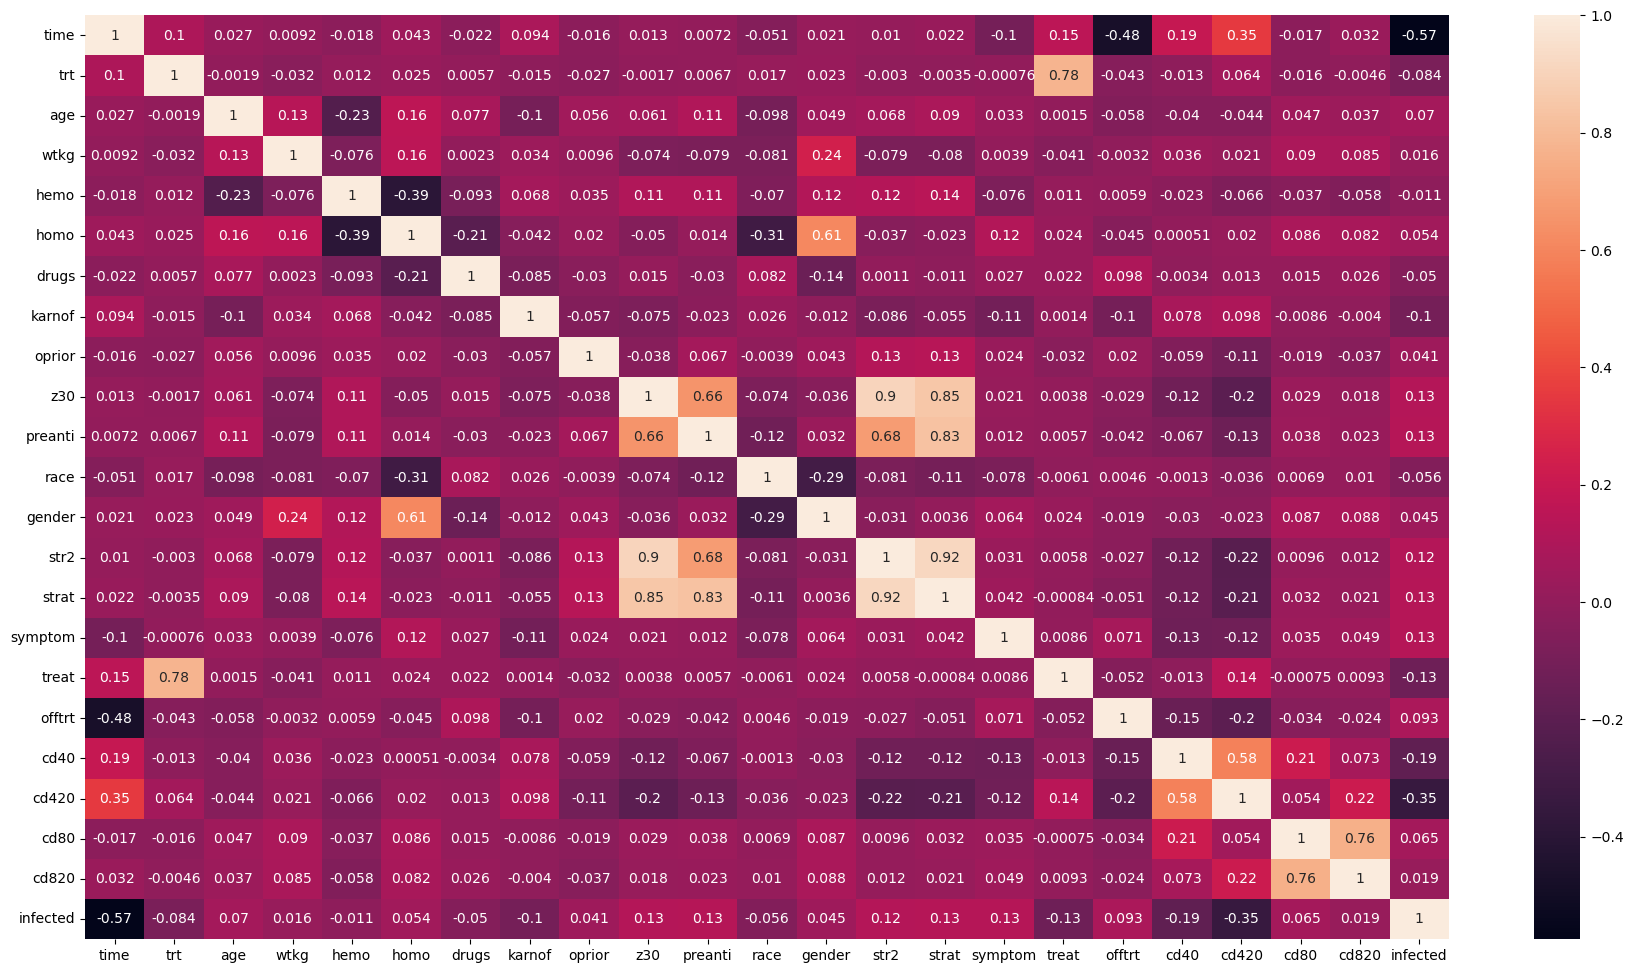

In [11]:
plt.figure(figsize=(22,12))
sns.heatmap(data=df.corr(), annot=True)

# Separate Features

In [12]:
X,y = df.drop("infected", axis=1), df['infected']

# Baseline Model

In [13]:
model = DummyClassifier(strategy="constant", constant=1)
scores = evaluate_model(X,y, model)
print('>%.3f (%.3f)' % (np.mean(scores), np.std(scores)))

>0.392 (0.001)


# Advanced Model Metrics

In [16]:
names = ['LDA', 'LR', 'SVC', 'GNB', "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

,Model,Mean,STD
1,LR,0.758936,0.028068
0,LDA,0.756366,0.023570
2,SVC,0.743570,0.030941
3,GNB,0.671490,0.035668
4,GPC,0.558264,0.038388


In [17]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X, y)

,Model,Mean,STD
3,GBC,0.761965,0.026160
0,RFC,0.752764,0.027418
2,XGB,0.747900,0.030934
1,DTC,0.683609,0.029156


# Test Models with Different Sampling Tecnhiques

# Test With Smote First

In [21]:
X_smote, y_smote = get_over_sampling_methods(X, y, "SMOTE")

In [22]:
names = ['LDA', 'LR', 'SVC', 'GNB', "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
2,SVC,0.907909,0.011213
1,LR,0.894593,0.012511
0,LDA,0.881543,0.012879
4,GPC,0.873136,0.010341
3,GNB,0.848438,0.013648


In [23]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_smote, y_smote)

,Model,Mean,STD
0,RFC,0.926714,0.008564
2,XGB,0.924944,0.006173
3,GBC,0.914895,0.008414
1,DTC,0.886028,0.007004


# Signficiant improvement after using Smote but lets try other over sampling methods

# ADASYN 

In [29]:
X_adasyn, y_adasyn = get_over_sampling_methods(X, y, "ADASYN")

In [30]:
names = ['LDA', 'LR', 'SVC', 'GNB', "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_adasyn, y_adasyn)

,Model,Mean,STD
2,SVC,0.912946,0.008412
4,GPC,0.885182,0.010562
1,LR,0.881478,0.009929
0,LDA,0.877917,0.010011
3,GNB,0.840520,0.011826


In [31]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_adasyn, y_adasyn)

,Model,Mean,STD
0,RFC,0.928597,0.007559
2,XGB,0.928450,0.007868
3,GBC,0.915729,0.008009
1,DTC,0.881826,0.011091


# Borderline SMOTE

In [32]:
X_bl, y_bl = get_over_sampling_methods(X, y, "BL-SMOTE")

In [33]:
names = ['LDA', 'LR', 'SVC', 'GNB', "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_bl, y_bl)

,Model,Mean,STD
2,SVC,0.910407,0.010881
0,LDA,0.885895,0.010427
1,LR,0.885446,0.011441
4,GPC,0.878892,0.013955
3,GNB,0.835106,0.012441


In [34]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_bl, y_bl)

,Model,Mean,STD
0,RFC,0.931717,0.007447
2,XGB,0.927410,0.006100
3,GBC,0.912000,0.004983
1,DTC,0.890493,0.011283


# BL Smote gave us our highest scores so far but lets continue to test with KNN smote

In [35]:
X_knn, y_knn = get_over_sampling_methods(X, y, "KNN-SMOTE")

In [36]:
names = ['LDA', 'LR', 'SVC', 'GNB', "GPC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_knn, y_knn)

,Model,Mean,STD
2,SVC,0.907909,0.011213
1,LR,0.894593,0.012511
0,LDA,0.881543,0.012879
4,GPC,0.873136,0.010341
3,GNB,0.848438,0.013648


In [37]:
names = ['RFC', 'DTC', 'XGB', 'GBC']
models = get_selected_models(names)
testing_selected_models(names, models, X_knn, y_knn)

,Model,Mean,STD
2,XGB,0.924944,0.006173
0,RFC,0.924842,0.008440
3,GBC,0.914712,0.008393
1,DTC,0.885226,0.008241


# Lets Test out an MLP Model and see how it does against this problem

In [38]:
def create_keras_classifier(function, optimizer, idx, param, validation_data):
    if idx == 0 or idx ==3:
        
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer)
            , epochs=400, 
            batch_size=128, 
            verbose=0,
            validation_data= validation_data
            )
    elif idx ==1:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
        
    else:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
    return model

def create_model_dropout(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerl2(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', kernel_regularizer=l2(param) ))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerL1(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu', activity_regularizer=l1(param) ))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_without_reg(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

functions = [
  create_model_dropout,
  create_model_regularizerL1,
  create_model_regularizerl2,
  create_model_without_reg
]

optimizers = [
    Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07),
    SGD(lr=0.01, momentum=0.9), 
    SGD(lr=0.001, momentum=0.9),
    ]
optimizer_names = ['Adam', "RmsProp", "SGD:0.01", "SGD:0.001"]
function_names = ["Dropout", "L1", "L2", 'Without_Reg']
values = [1e-1, 1e-2, 1e-3, 1e-4]
model_performance = []
for index, function in enumerate(functions):
    name = function_names[index]
    for idx, optimizer in enumerate(optimizers):
        optimizer_name = optimizer_names[idx]
        value = values[idx]
        model = create_keras_classifier(function, optimizer, index, value, (X_val, y_val))
        
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy,
            "Optimizer": optimizer_name,
            "Value": value
        })
model_df = pd.DataFrame(model_performance)
end_result = model_df.sort_values(by="Accuracy", ascending=False)
end_result

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_53579/4136838655.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
2024-05-05 19:01:06.915960: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_53579/4136838655.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
/var/folders/bb/2qsf8cm95jg05

,Model,Accuracy,Optimizer,Value
8,L2,0.867188,Adam,0.1000
0,Dropout,0.854968,Adam,0.1000
1,Dropout,0.849920,RmsProp,0.0100
12,Without_Reg,0.831931,Adam,0.1000
13,Without_Reg,0.823958,RmsProp,0.0100
4,L1,0.817708,Adam,0.1000
6,L1,0.815104,SGD:0.01,0.0010
7,L1,0.815104,SGD:0.001,0.0001
9,L2,0.815104,RmsProp,0.0100
10,L2,0.815104,SGD:0.01,0.0010


# SVM Tune

Best parameters: {'model__C': 1, 'model__kernel': 'rbf'}
Best cross-validation score: 0.913
Test accuracy: 0.900
              precision    recall  f1-score   support

           0       0.89      0.92      0.90       502
           1       0.91      0.88      0.89       469

    accuracy                           0.90       971
   macro avg       0.90      0.90      0.90       971
weighted avg       0.90      0.90      0.90       971



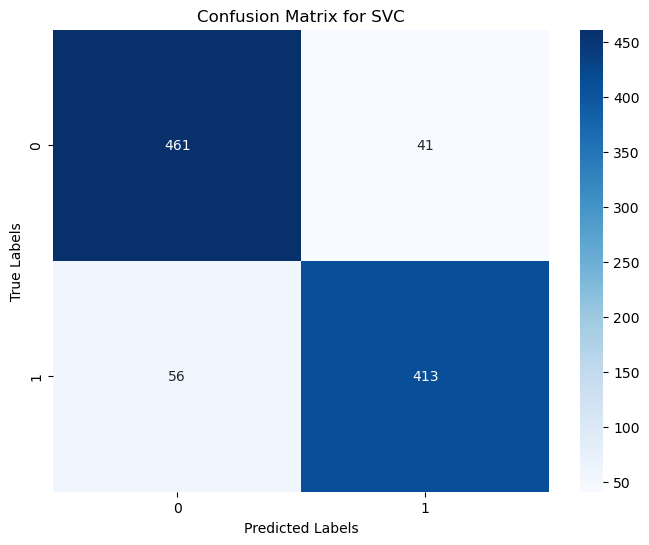

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('power_transformer',
                                        PowerTransformer()),
                                       ('model', SVC())]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                      0.9, 1],
                         'model__kernel': ['linear', 'poly', 'rbf', 'sigmoid']},
             scoring='accuracy')

In [54]:
svm_tune_grid_search(X_bl, y_bl)

# LR Tune

Best parameters: {'model__C': 0.5, 'model__solver': 'newton-cg'}
Best cross-validation score: 0.889
Test accuracy: 0.871
              precision    recall  f1-score   support

           0       0.86      0.89      0.88       502
           1       0.88      0.85      0.86       469

    accuracy                           0.87       971
   macro avg       0.87      0.87      0.87       971
weighted avg       0.87      0.87      0.87       971



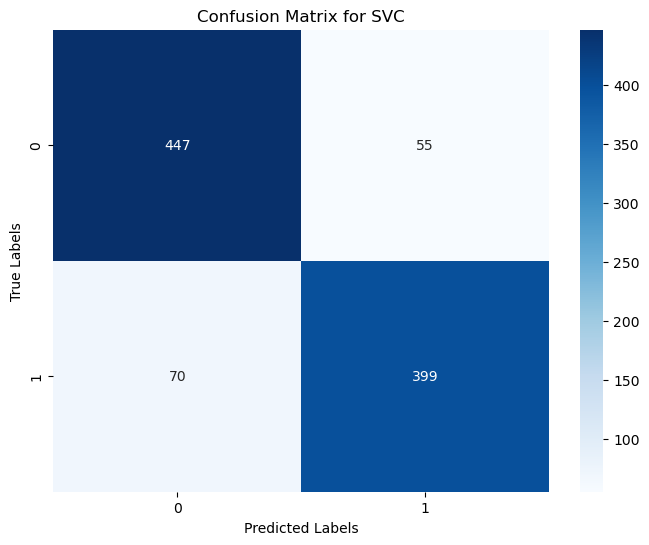

In [57]:
logistic_regression_tune_cv(X_bl, y_bl)

# Hyper Parameters Tree Models Tune

Best score for DTC: 0.890
Best parameters: {'model__criterion': 'entropy', 'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__min_samples_split': 5, 'model__splitter': 'best'}
Validation Test accuracy for DTC: 0.889
Test accuracy for DTC: 0.893
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       247
           1       0.87      0.92      0.89       239

    accuracy                           0.89       486
   macro avg       0.89      0.89      0.89       486
weighted avg       0.89      0.89      0.89       486



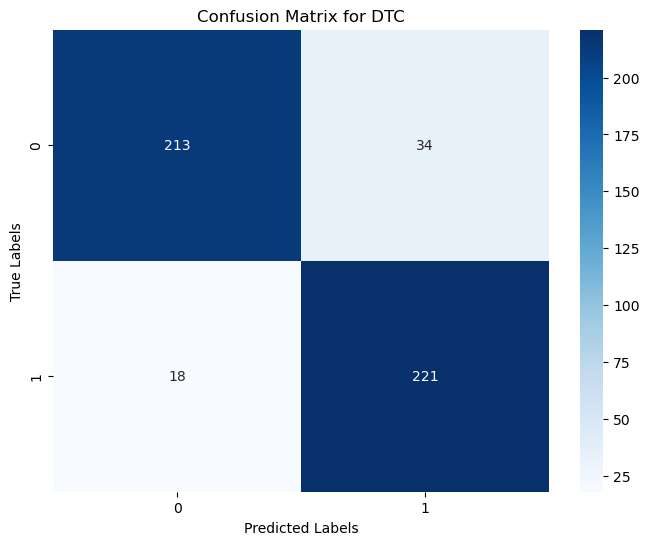

Best score for RFC: 0.925
Best parameters: {'model__max_depth': 20, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Validation Test accuracy for RFC: 0.942
Test accuracy for RFC: 0.928
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.92      0.93       247
           1       0.92      0.94      0.93       239

    accuracy                           0.93       486
   macro avg       0.93      0.93      0.93       486
weighted avg       0.93      0.93      0.93       486



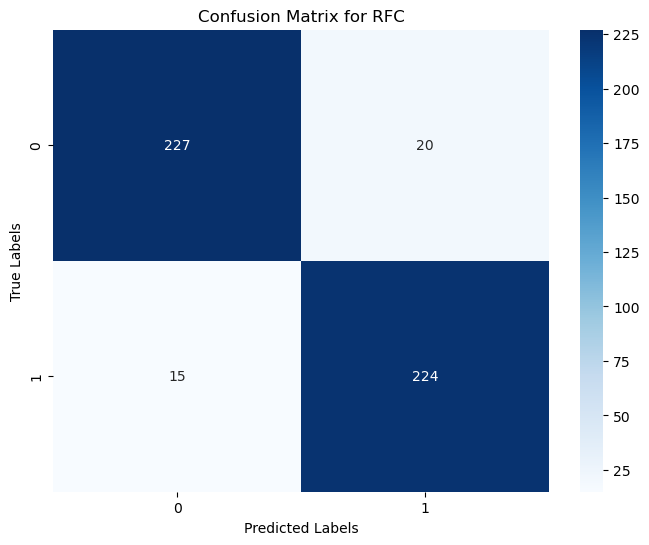

Best score for GBC: 0.924
Best parameters: {'model__learning_rate': 0.2, 'model__max_depth': 5, 'model__n_estimators': 200}
Validation Test accuracy for GBC: 0.944
Test accuracy for GBC: 0.922
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.94      0.91      0.92       247
           1       0.91      0.94      0.92       239

    accuracy                           0.92       486
   macro avg       0.92      0.92      0.92       486
weighted avg       0.92      0.92      0.92       486



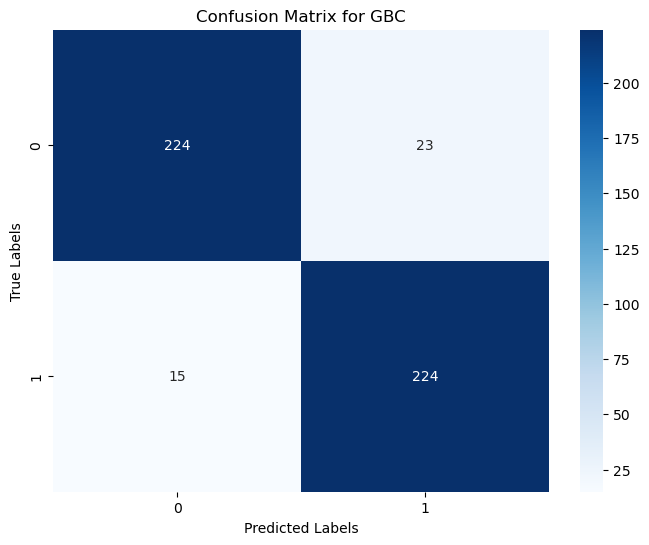

Best score for XGB: 0.925
Best parameters: {'model__learning_rate': 0.1, 'model__max_depth': 7, 'model__n_estimators': 200}
Validation Test accuracy for XGB: 0.936
Test accuracy for XGB: 0.926
---------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.91      0.93       247
           1       0.91      0.95      0.93       239

    accuracy                           0.93       486
   macro avg       0.93      0.93      0.93       486
weighted avg       0.93      0.93      0.93       486



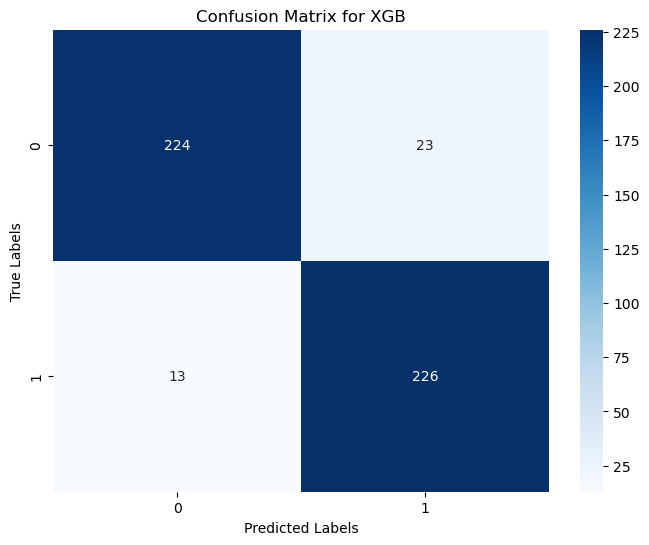

In [58]:
names = ["DTC", "RFC", "GBC", "XGB"]
models = get_selected_models(names)

param_grid = {
    'DTC': {
        'model__criterion': ['gini', 'entropy'],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
        'model__splitter': ['best', 'random'] 
    },
    'RFC': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [None, 10, 20, 30],
        'model__min_samples_split': [2, 5, 10],
        'model__min_samples_leaf': [1, 2, 4],
    },
    'GBC': {
        'model__n_estimators': [100, 200, 300],
        'model__learning_rate': [0.01, 0.1, 0.2],
        'model__max_depth': [3, 5, 7]
    },
    'XGB': {
        'model__n_estimators': [100, 200, 300],
        'model__max_depth': [3, 5, 7],
        'model__learning_rate': [0.01, 0.1, 0.2]
    }
}

metric = make_scorer(f1_score)
val_grid_search_selected_models(param_grid, names, models, X_bl, y_bl, metric)

# Feature Selection

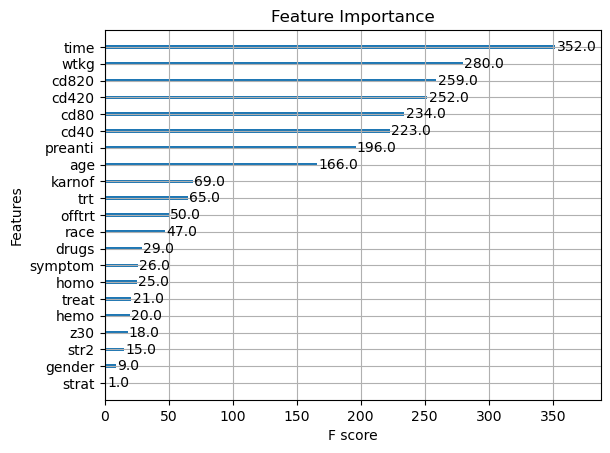

In [59]:
import xgboost as xgb

model = xgb.XGBClassifier()
model.fit(X_bl, y_bl)

importances = model.feature_importances_

xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

In [62]:
pca_analysis(X_bl)

,Number of Components,Cumulative Explained Variance
0,1,0.165107
1,2,0.264858
2,3,0.359025
3,4,0.440210
4,5,0.512713
5,6,0.571104
6,7,0.620691
7,8,0.667113
8,9,0.711361
9,10,0.755211


# Our PCA Analysis shows 70-95% of the variance between 9-16 columns. This means we might be able to retain accuract while reducing our feature dimensionality

# Testing with F stat

In [65]:
names = ["RFC", "XGB", "GBC"]
models = [
  RandomForestClassifier(max_depth=20,min_samples_leaf=1,min_samples_split=2,n_estimators=100),
  XGBClassifier(learning_rate=0.1,max_depth=7,n_estimators=200),
  GradientBoostingClassifier(learning_rate=0.2,max_depth=5, n_estimators=200)
]
variance_window = range(9, 22+1)
metric = f_classif
test_k_best_columns(names, models, X_bl, y_bl, metric,'F-Stat', variance_window)

,Model,Col #,Metric,Mean,STD
39,RFC,22,F-Stat,0.931274,0.004616
21,RFC,16,F-Stat,0.931026,0.005557
36,RFC,21,F-Stat,0.930741,0.007748
37,XGB,21,F-Stat,0.930095,0.006149
24,RFC,17,F-Stat,0.929601,0.007083
22,XGB,16,F-Stat,0.929477,0.006561
30,RFC,19,F-Stat,0.929448,0.006590
40,XGB,22,F-Stat,0.929404,0.005859
33,RFC,20,F-Stat,0.929059,0.007080
31,XGB,19,F-Stat,0.928864,0.006721


# Looking at the results we receive fairly high accuracy scores with just 9 columns but lets test with mutal information and see what works best

In [67]:
names = ["RFC", "XGB", "GBC"]
models = [
  RandomForestClassifier(max_depth=20,min_samples_leaf=1,min_samples_split=2,n_estimators=100),
  XGBClassifier(learning_rate=0.1,max_depth=7,n_estimators=200),
  GradientBoostingClassifier(learning_rate=0.2,max_depth=5, n_estimators=200)
]
variance_window = range(9, 22+1)
metric = mutual_info_classif
test_k_best_columns(names, models, X_bl, y_bl, metric,'Mutal-Info', variance_window)

,Model,Col #,Metric,Mean,STD
33,RFC,20,Mutal-Info,0.930907,0.007665
39,RFC,22,Mutal-Info,0.929884,0.005057
36,RFC,21,Mutal-Info,0.929633,0.007077
27,RFC,18,Mutal-Info,0.929619,0.005365
40,XGB,22,Mutal-Info,0.929404,0.005859
30,RFC,19,Mutal-Info,0.929014,0.005451
34,XGB,20,Mutal-Info,0.928209,0.007839
37,XGB,21,Mutal-Info,0.928010,0.006513
25,XGB,17,Mutal-Info,0.927781,0.007122
28,XGB,18,Mutal-Info,0.926165,0.008879


# Mutal Information performs better than F-Stat, however it is hard to pick the single best model with the most optimal number of columns

              precision    recall  f1-score   support

           0       0.95      0.91      0.93       247
           1       0.92      0.95      0.93       239

    accuracy                           0.93       486
   macro avg       0.93      0.93      0.93       486
weighted avg       0.93      0.93      0.93       486



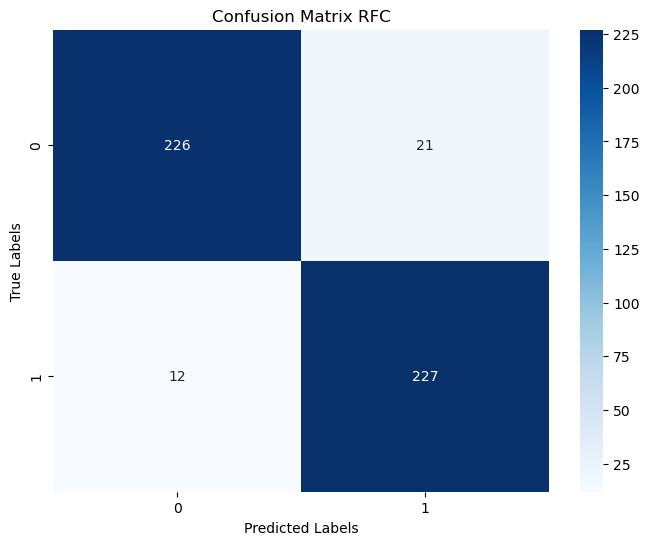

              precision    recall  f1-score   support

           0       0.94      0.90      0.92       247
           1       0.90      0.95      0.92       239

    accuracy                           0.92       486
   macro avg       0.92      0.92      0.92       486
weighted avg       0.92      0.92      0.92       486



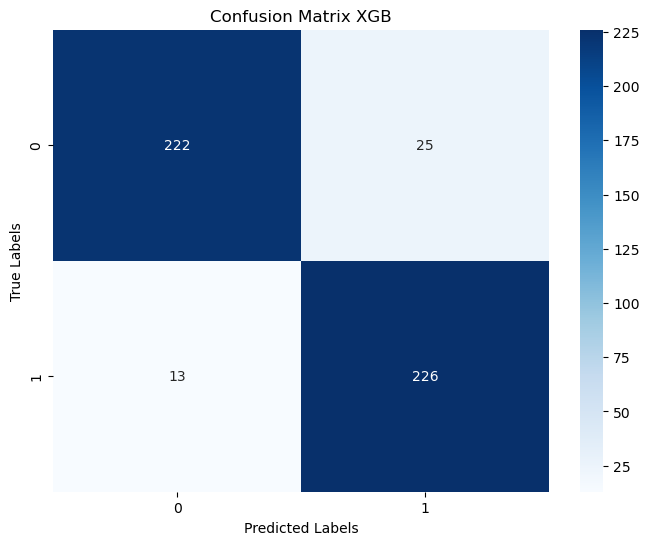

              precision    recall  f1-score   support

           0       0.95      0.90      0.92       247
           1       0.90      0.95      0.92       239

    accuracy                           0.92       486
   macro avg       0.92      0.92      0.92       486
weighted avg       0.93      0.92      0.92       486



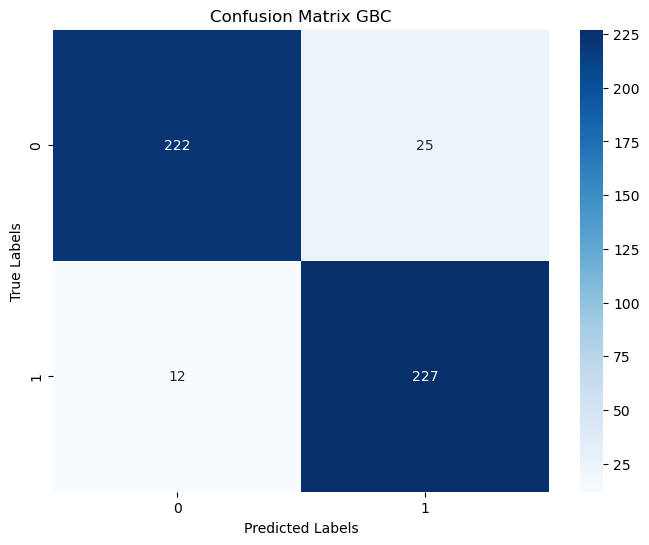

,Model,Validation Accuracy,Test Accuracy
0,RFC,0.940206,0.932099
2,GBC,0.938144,0.923868
1,XGB,0.936082,0.921811


In [70]:
names = ["RFC", "XGB", "GBC"]
models = [
  RandomForestClassifier(max_depth=20,min_samples_leaf=1,min_samples_split=2,n_estimators=100),
  XGBClassifier(learning_rate=0.1,max_depth=7,n_estimators=200),
  GradientBoostingClassifier(learning_rate=0.2,max_depth=5, n_estimators=200)
]
metric = mutual_info_classif

test_train_test_val_splits_on_models(names, models, X_bl, y_bl, 17, 'Mutal-Info')